In [1]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.WaveformAnalysis import Waveform
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os, glob, itertools
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

In [2]:
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
parameters = 'simulations'
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx',
                                         parameters)
analysis_config.GetChannelMapFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx',
                                         parameters)
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3*\
analysis_config.run_parameters['Sampling Rate [MHz]']/analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']/\
analysis_config.run_parameters['Sampling Rate [MHz]']*analysis_config.run_parameters['Simulation Sampling Rate [MHz]']
path_to_reduced = '/p/lustre1/jacopod/30th/'
!ls $path_to_reduced

20200911_OvernightBi207_AfterFilling
20200912_MorningNoise_PreRecirculation
20200915_Night_AfterFirstRnInjection
20200915_Night_Noise
20200916_Morning_Noise
20200916_Night_AfterSecondRnInjection
20200916_RnPoAlphaEffTest
20200917_Night_AfterThirdRnInjection
20200920_Rn220InParallel_RnPoTest
20200921_Afternoon_AfterFourthInjection
20200922_Afternoon_AfterFifthInjection
20200923_Afternoon_AfterSixthInjection
20200924_Afternoon_AfterSeventhInjection
20201207_alpha_sim
20210502_bipo_sim
config
selected_dataset


In [9]:
path_to_reduced_data = '/p/lustre1/jacopod/30th/'
df_data = pd.read_pickle(path_to_reduced_data + 'selected_dataset/alpha_rich_500ns.p')
#df_data = df_data[(df_data['TileStrip X1-12 Charge Energy'] < 50) & (df_data['TileStrip Y1-10 Charge Energy'] < 50)]
data_DriftTime = (df_data['TimeOfMaxChannel'] - analysis_config.run_parameters['Pretrigger Length [samples]'])\
*analysis_config.run_parameters['Sampling Period [ns]']/1.e3

In [10]:
df_data = df_data[(data_DriftTime>10) & (data_DriftTime<70)]
data_DriftTime = data_DriftTime[(data_DriftTime>10) & (data_DriftTime<70)]

In [11]:
df_sim = pd.read_pickle(path_to_reduced + '20201207_alpha_sim/test_noise_uncalibrated/reduced_added.p')
#df_sim = df_sim[(df_sim['TileStrip X1-12 Charge Energy'] < 50) & (df_sim['TileStrip Y1-10 Charge Energy'] < 50)]
DriftTime = (df_sim['TimeOfMaxChannel'] - trigger_time)*sampling_time
df_sim['Purity-Corrected Charge Energy'] = df_sim['TotalTileEnergy']*np.exp(DriftTime/100.0)
df_sim = df_sim[(DriftTime>10) & (DriftTime<70)]
DriftTime = DriftTime[(DriftTime>10) & (DriftTime<70)]

In [12]:
for k in df_sim.keys():
    print(k)

ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NoiseIndex
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-2 Baseline
SiPM 1-2 Baseline RMS
SiPM 1-2 Induced Charge
SiPM 1-2 Pulse Area
SiPM 1-2 Pulse Height
SiPM 1-2 Pulse Time
SiPM 1-2 T10
SiPM 1-2 T20
SiPM 1-2 T5
SiPM 1-2 T80
SiPM 1-2 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 1-4 T20
SiPM 1-4 T5
SiPM 1-4 T80
Si

In [13]:
mask_SS = df_sim['NumberOfClusters'] >0#== 1
alpha_band_charge = (df_sim['Purity-Corrected Charge Energy']>600-200*np.exp(-DriftTime/8)) &\
(df_sim['Purity-Corrected Charge Energy']<850-200*np.exp(-DriftTime/8))
alpha_band_SS = alpha_band_charge & mask_SS
alpha_band = (df_data['Purity-Corrected Charge Energy']>600-200*np.exp(-data_DriftTime/8)) &\
(df_data['Purity-Corrected Charge Energy']<850-200*np.exp(-data_DriftTime/8)) & (df_data['NumberOfClusters'] == 1)
lower_band = (df_data['Purity-Corrected Charge Energy']>300) & (df_data['Purity-Corrected Charge Energy']<600-200*np.exp(-data_DriftTime/8))

Text(0, 0.5, 'Purity Corrected Charge Energy [ADC counts]')

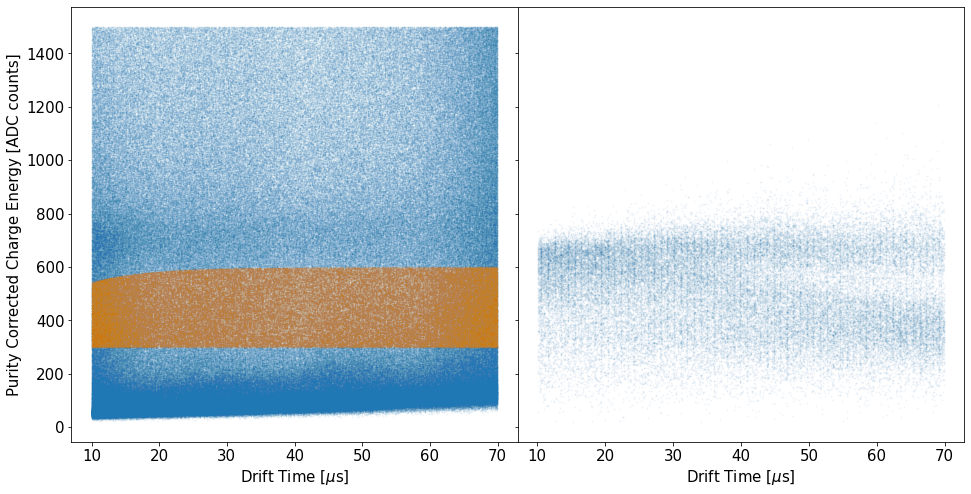

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,8),sharey=True,gridspec_kw={'wspace':0})
ax[0].scatter(data_DriftTime, df_data['Purity-Corrected Charge Energy'], s=0.5, alpha=0.05)
ax[0].set_xlabel('Drift Time [$\mu$s]')
ax[0].scatter(data_DriftTime[lower_band], df_data['Purity-Corrected Charge Energy'][lower_band], s=0.5, alpha=0.05)
ax[1].scatter(DriftTime, df_sim['Purity-Corrected Charge Energy'], s=1, alpha=0.05)
ax[1].set_xlabel('Drift Time [$\mu$s]')
ax[0].set_ylabel('Purity Corrected Charge Energy [ADC counts]')
#ax[1].scatter(DriftTime[np.logical_not(alpha_band_SS)], df_sim['Purity-Corrected Charge Energy'][np.logical_not(alpha_band_SS)], s=1, alpha=0.05)

In [15]:
rms_keys = []
ce_keys = []
for ch in analysis_config.channel_map['ChannelName'][analysis_config.channel_map['ChannelType'] == 'TileStrip']:
    rms_keys.append('TileStrip {} Baseline RMS'.format(ch))
    ce_keys.append('TileStrip {} Charge Energy'.format(ch))

TileStrip Y1-10 Baseline RMS


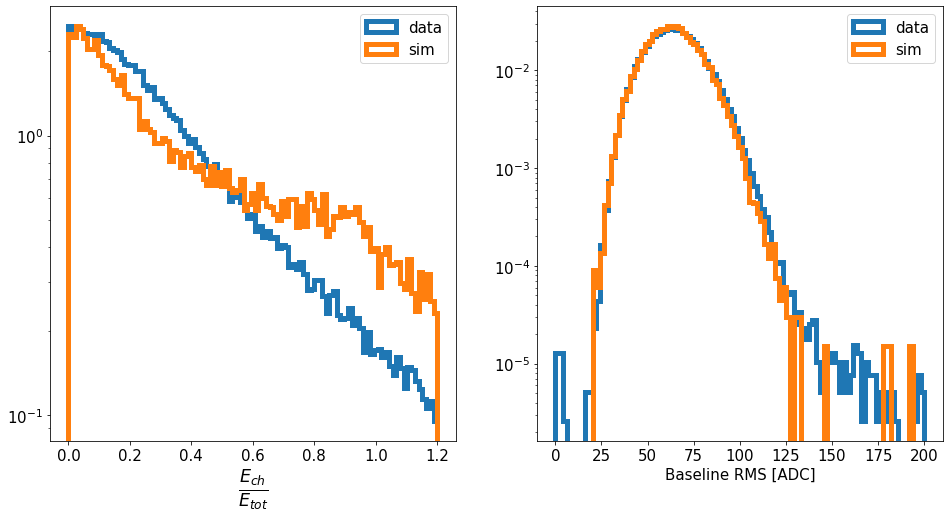

TileStrip Y11 Baseline RMS


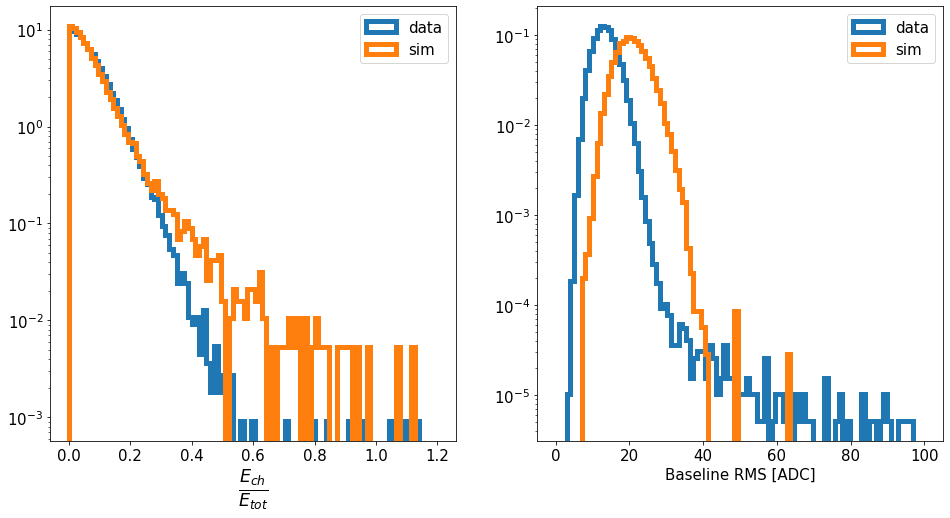

TileStrip Y12 Baseline RMS


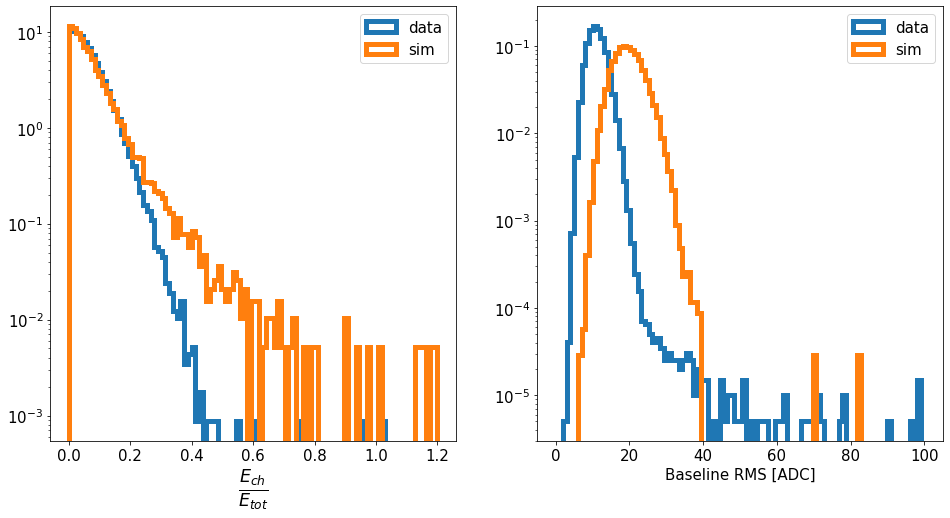

TileStrip Y13 Baseline RMS


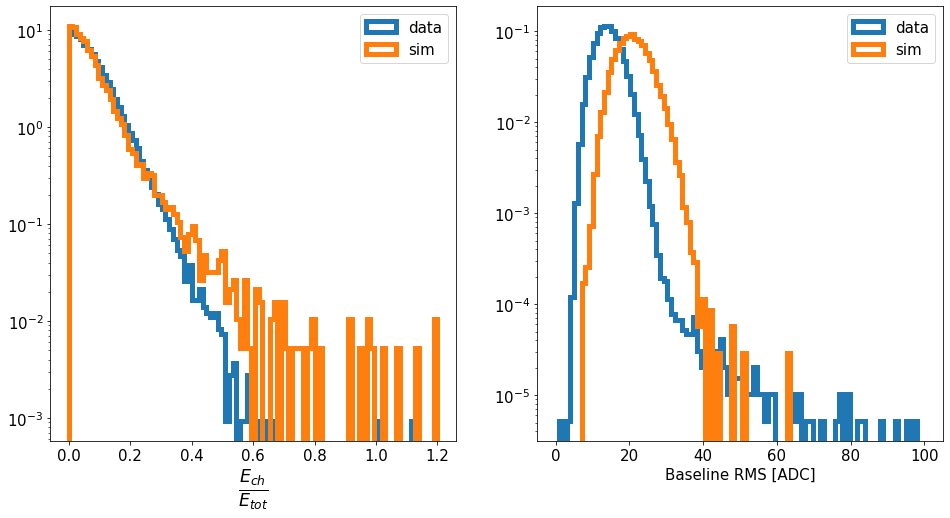

TileStrip Y14 Baseline RMS


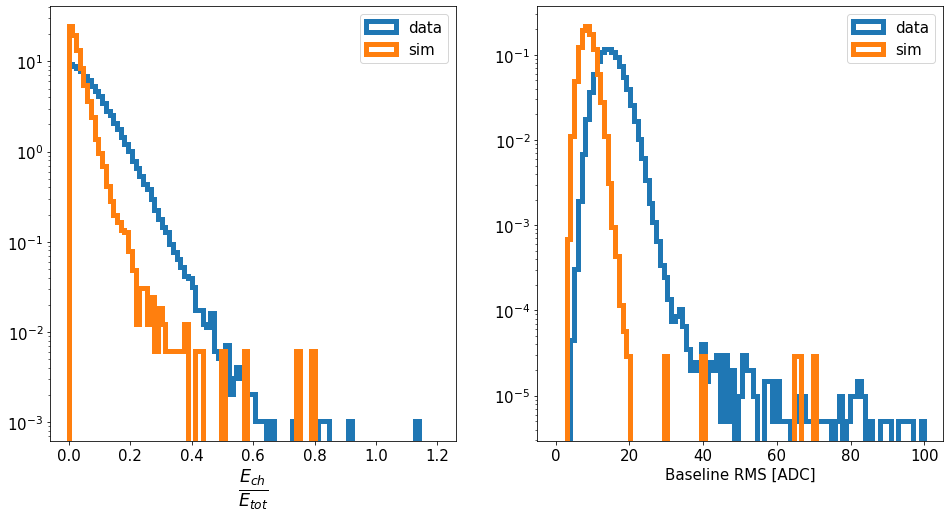

TileStrip Y15 Baseline RMS


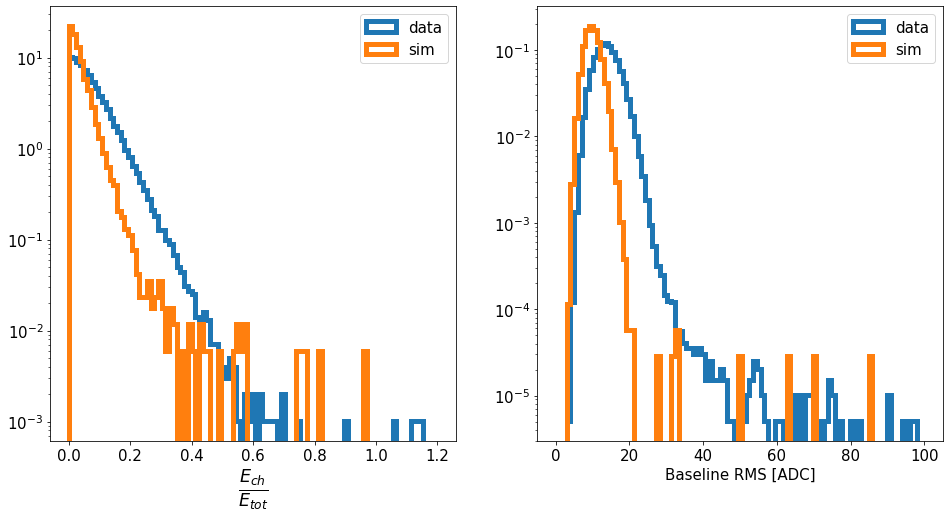

TileStrip Y16 Baseline RMS


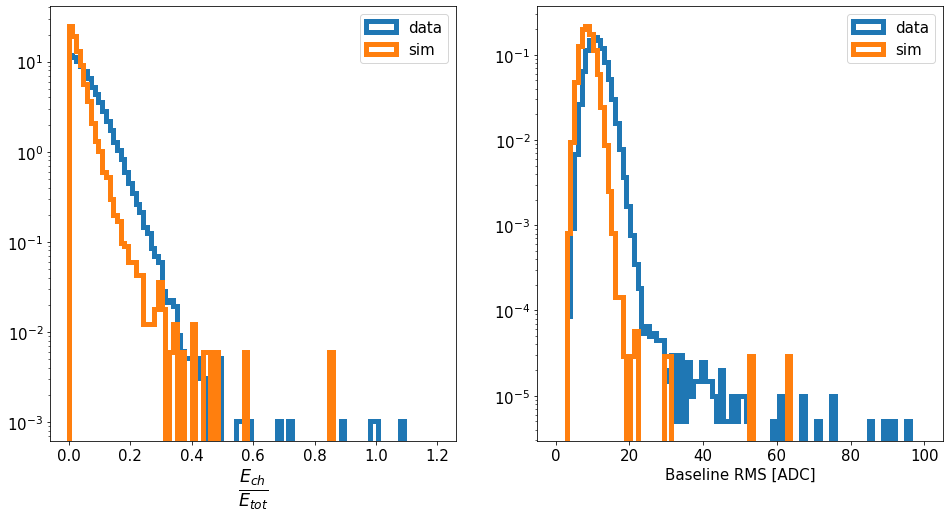

TileStrip Y17 Baseline RMS


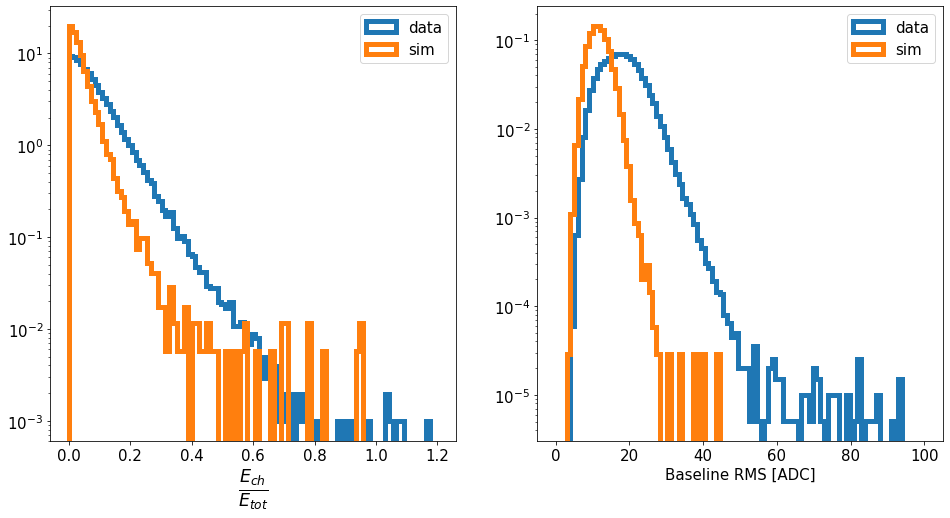

TileStrip Y18 Baseline RMS


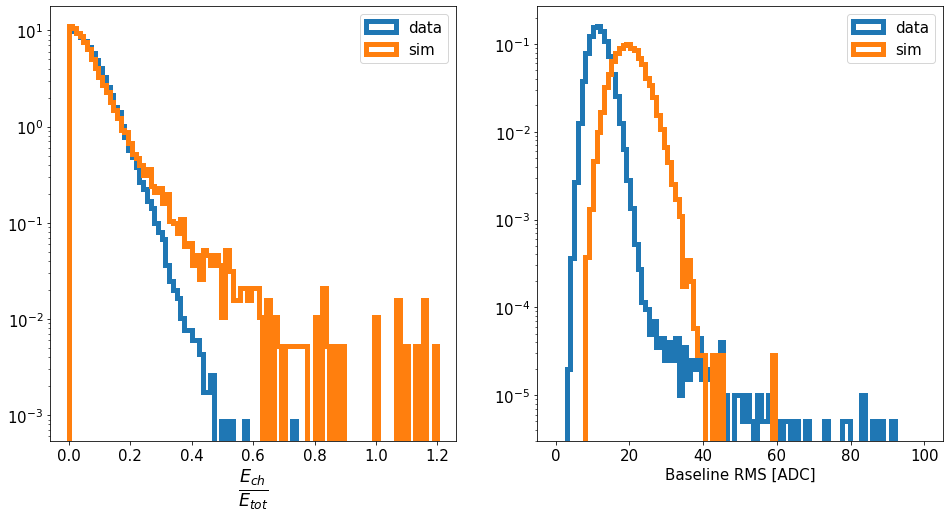

TileStrip Y19 Baseline RMS


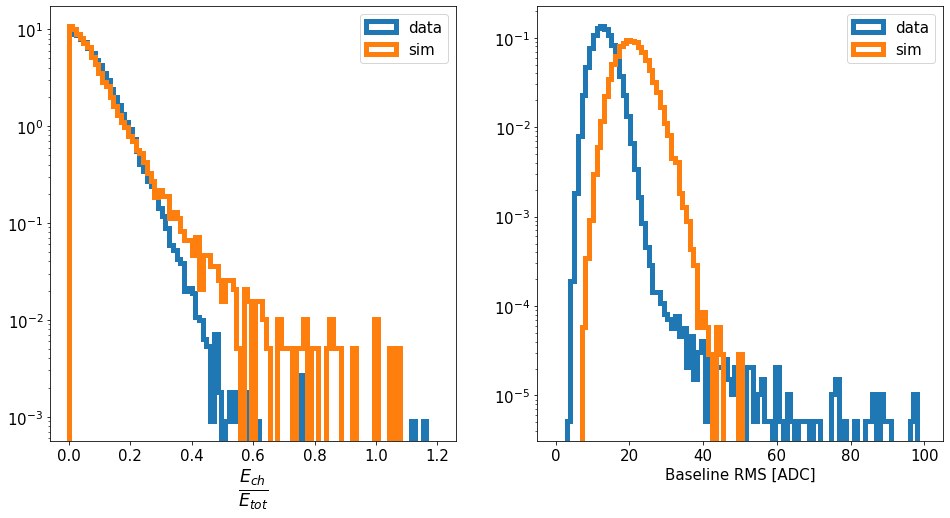

TileStrip Y20 Baseline RMS


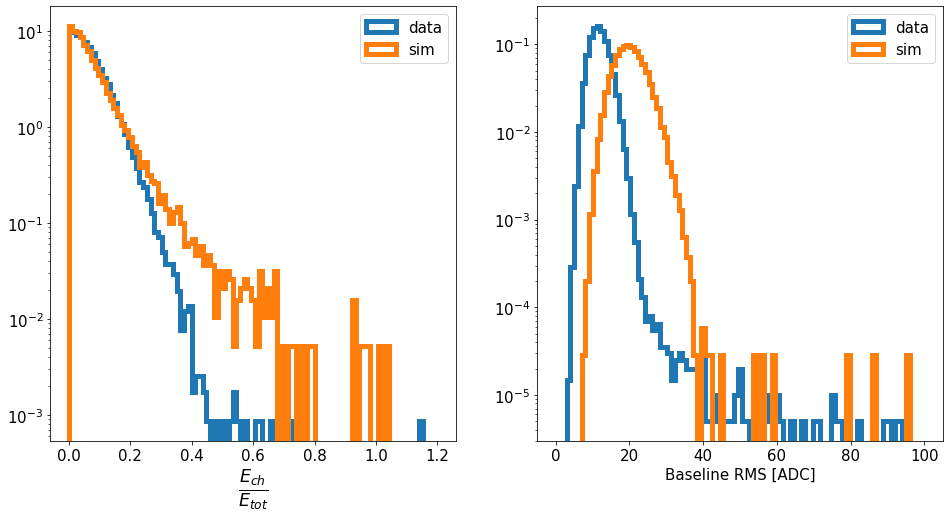

TileStrip Y21/22 Baseline RMS


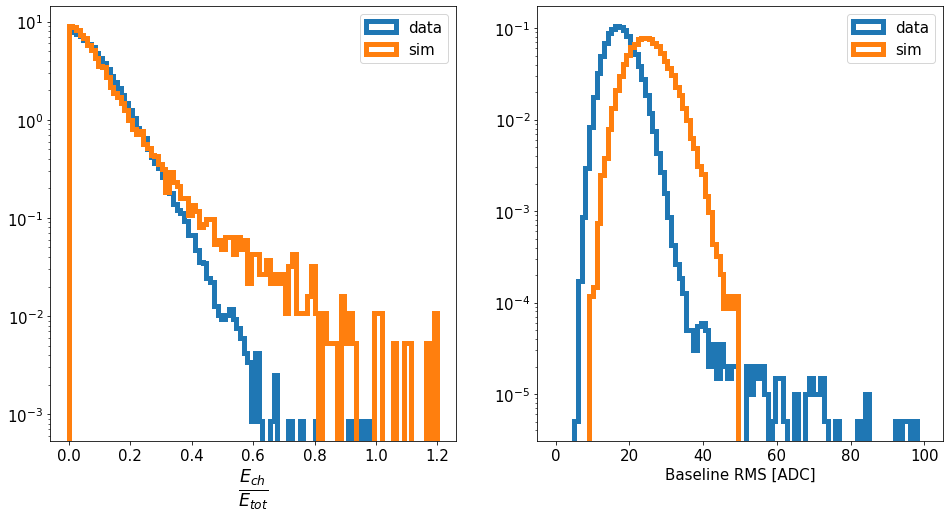

TileStrip Y23/24 Baseline RMS


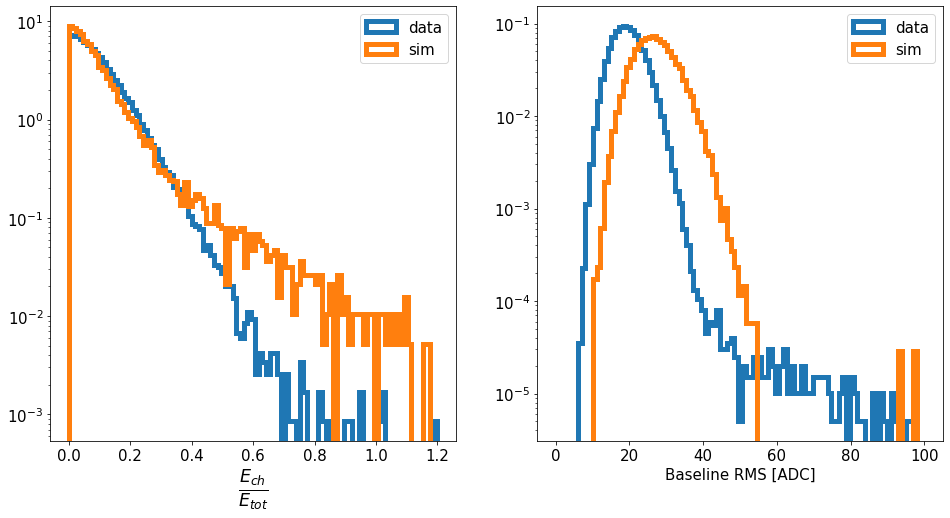

TileStrip Y27/28 Baseline RMS


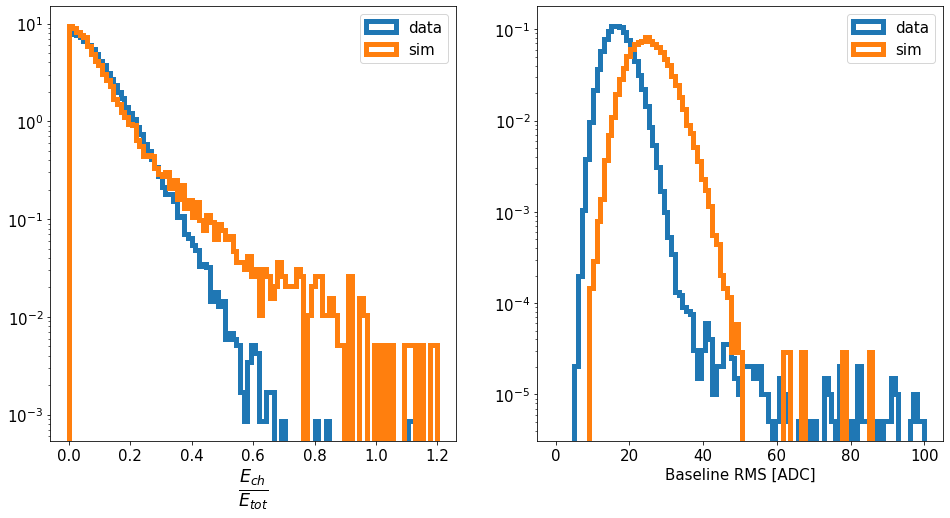

TileStrip Y29/30 Baseline RMS


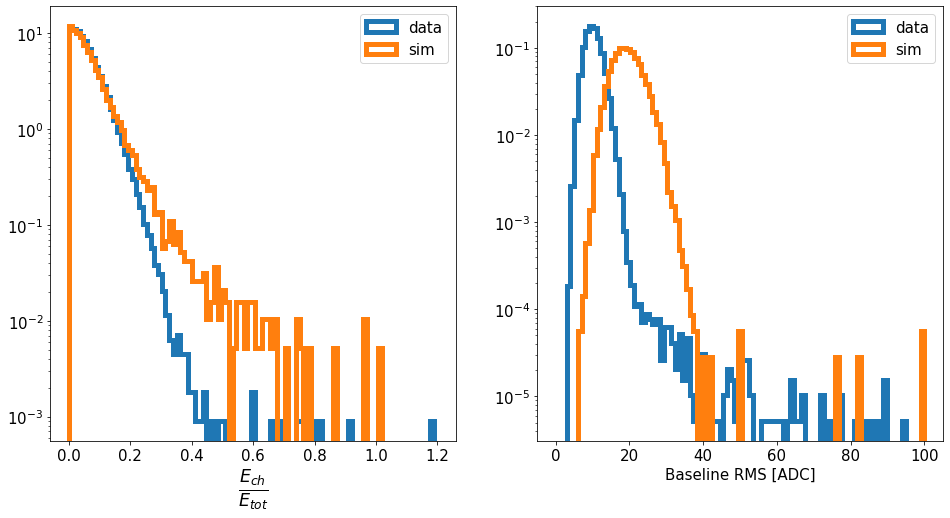

TileStrip X1-12 Baseline RMS


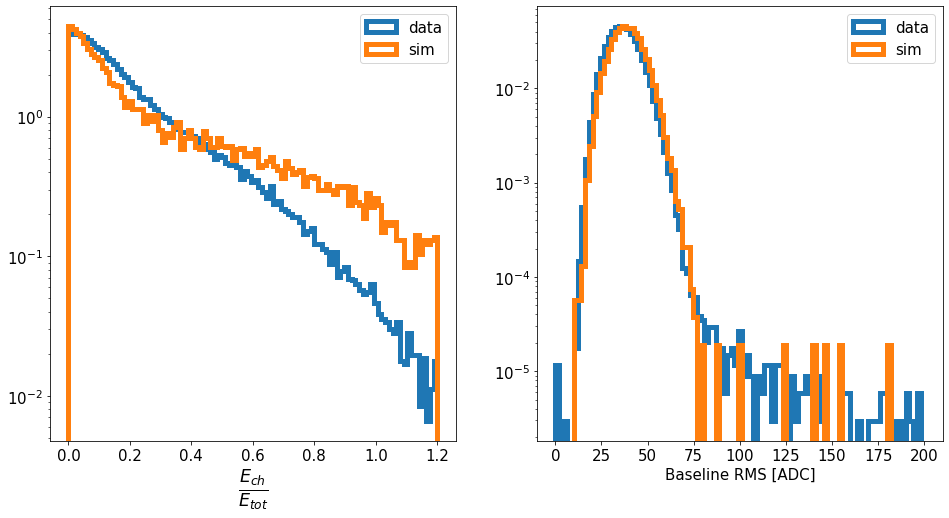

TileStrip X13 Baseline RMS


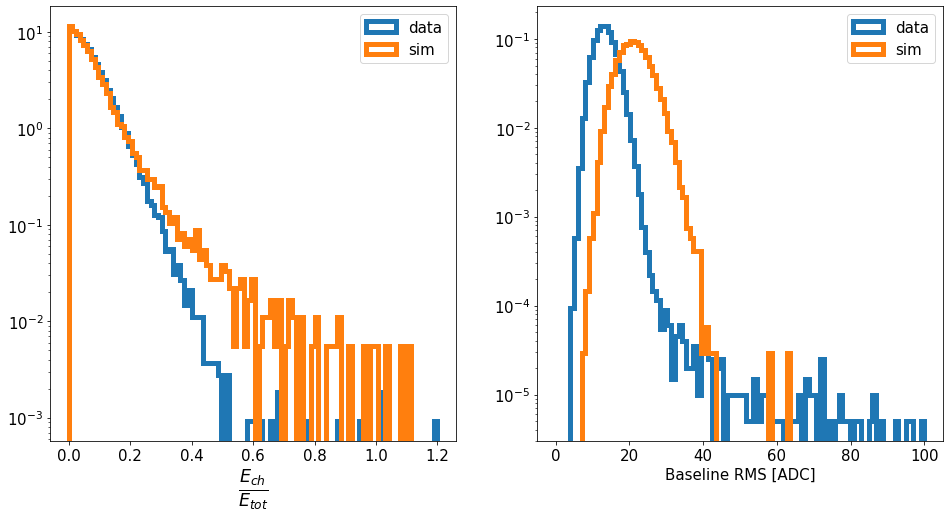

TileStrip X14 Baseline RMS


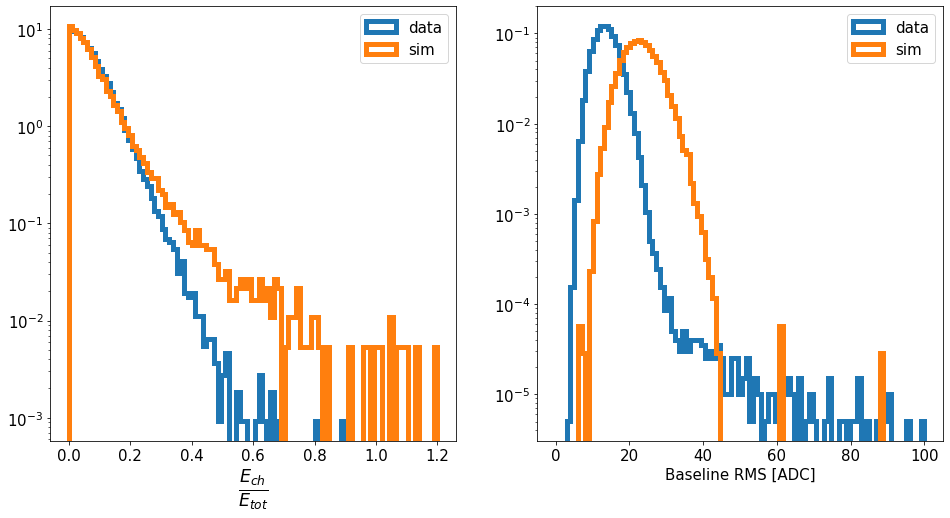

TileStrip X15 Baseline RMS


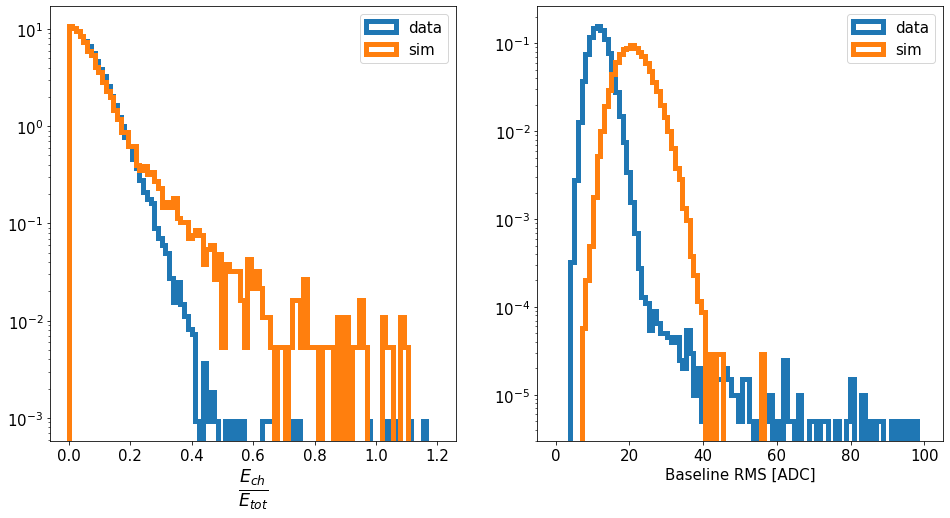

TileStrip X16 Baseline RMS


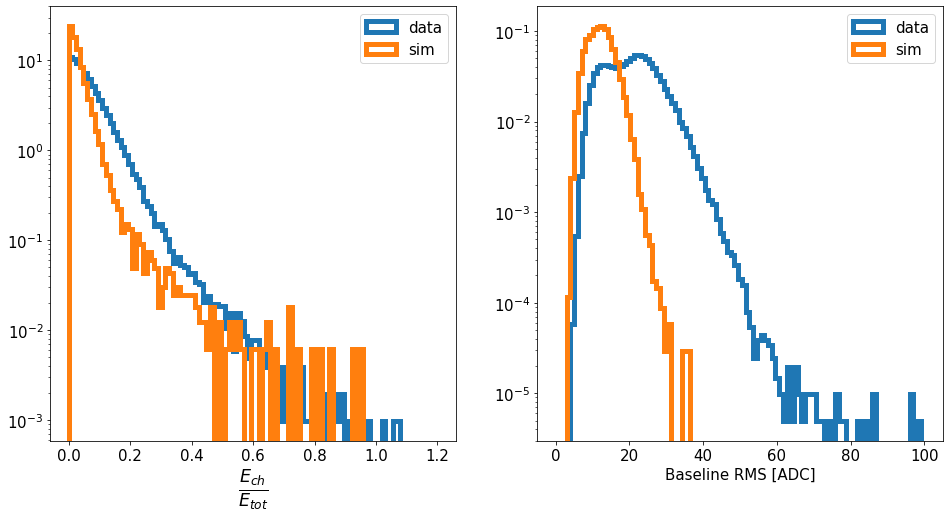

TileStrip X17 Baseline RMS


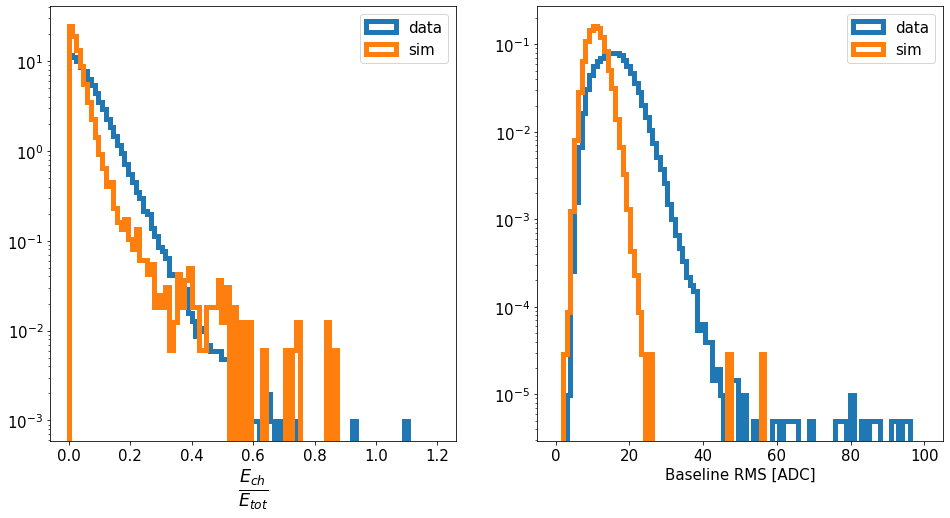

TileStrip X18 Baseline RMS


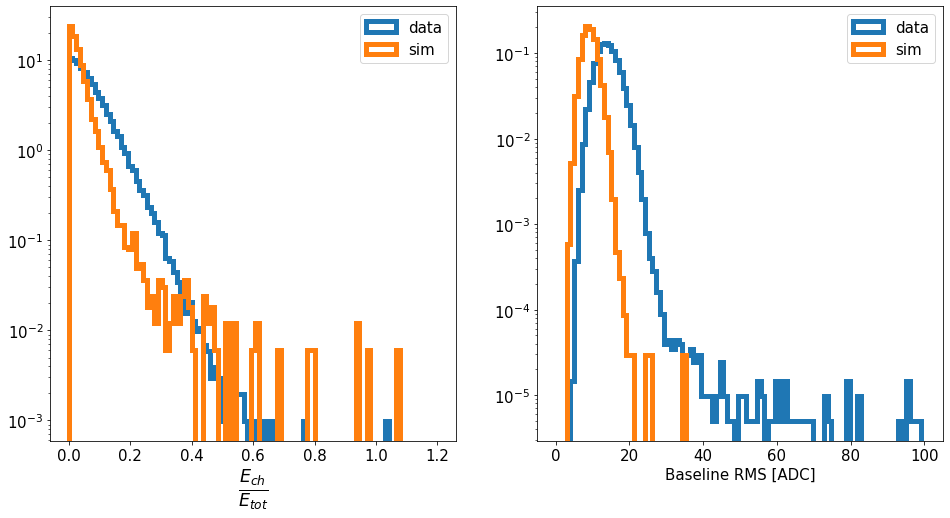

TileStrip X19 Baseline RMS


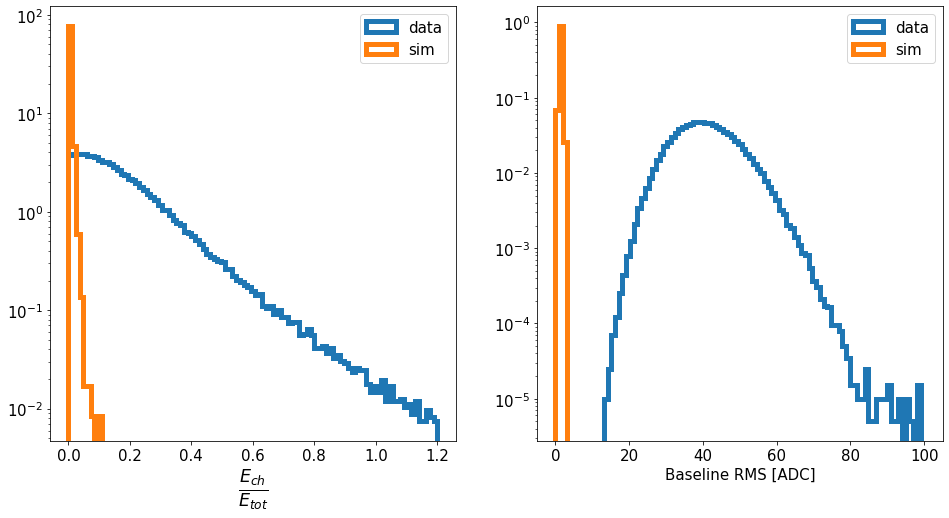

TileStrip X20 Baseline RMS


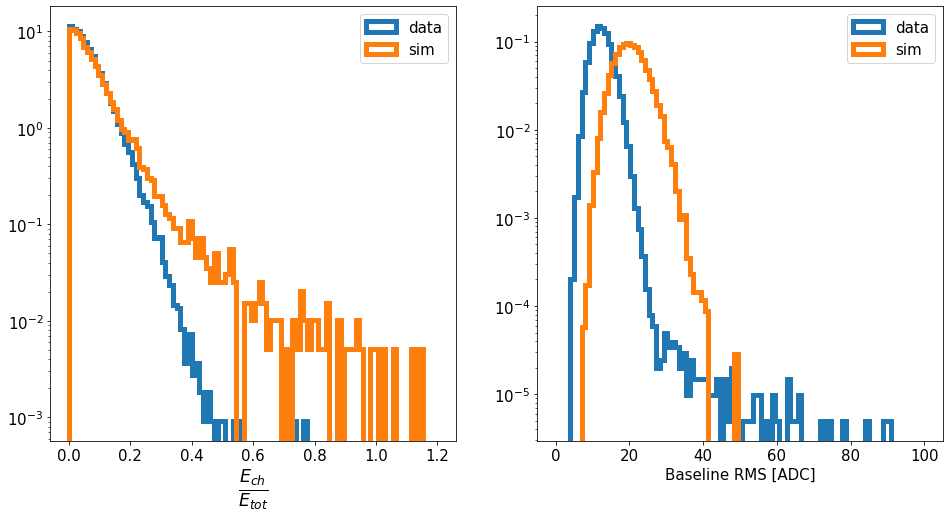

TileStrip X21 Baseline RMS


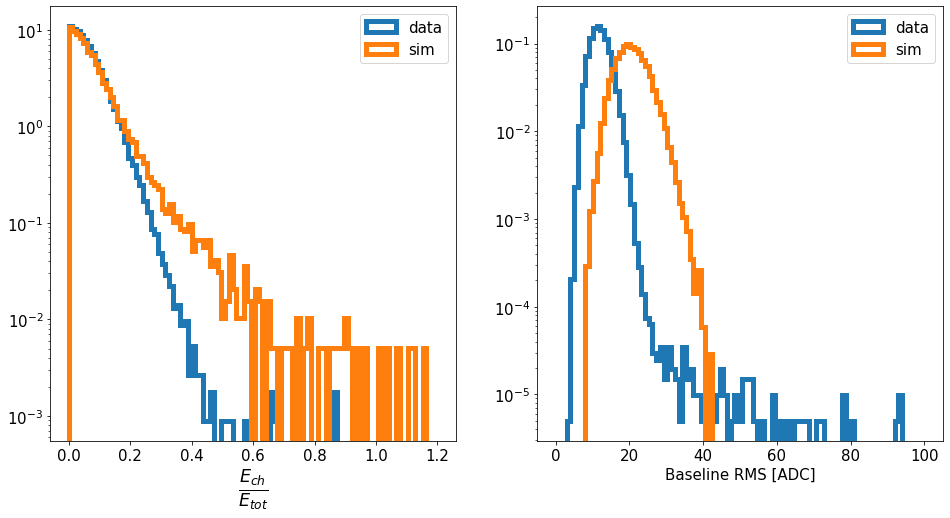

TileStrip X22 Baseline RMS


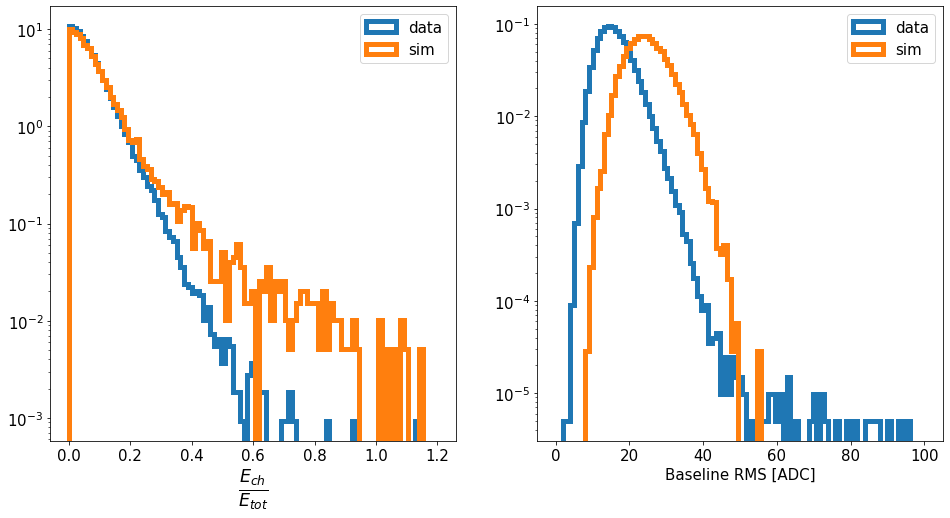

TileStrip X23/24 Baseline RMS


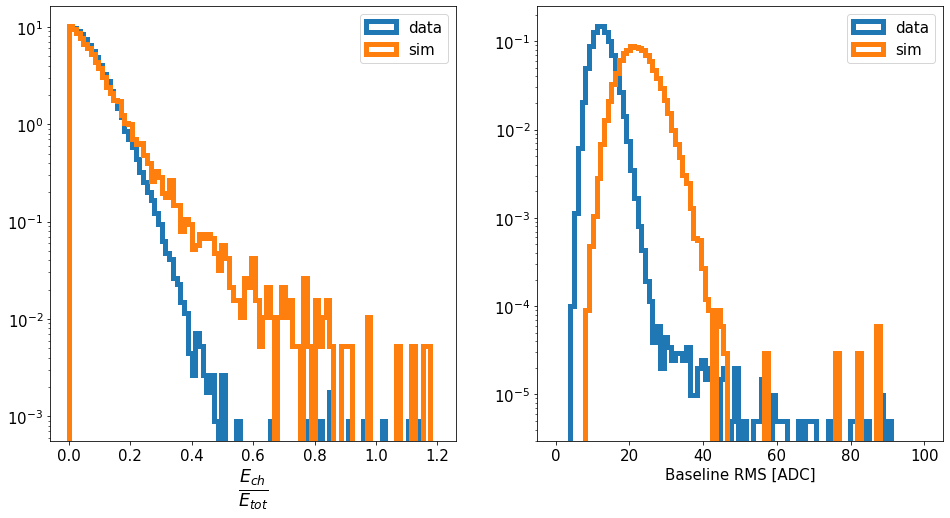

TileStrip X25/26 Baseline RMS


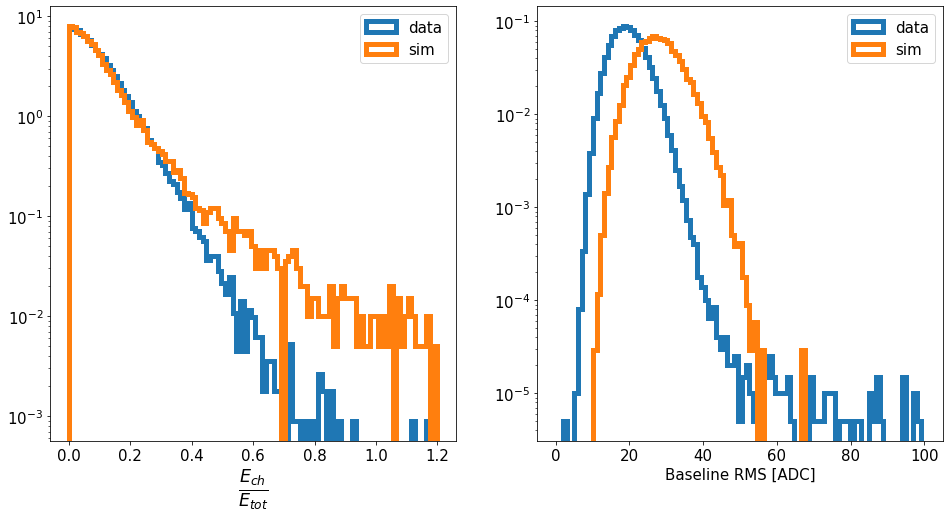

TileStrip X27/28 Baseline RMS


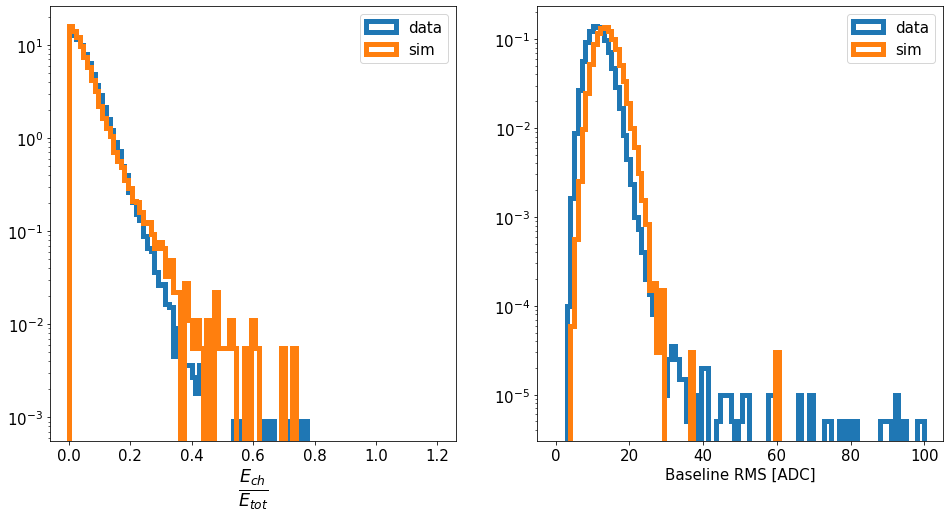

TileStrip X29/30 Baseline RMS


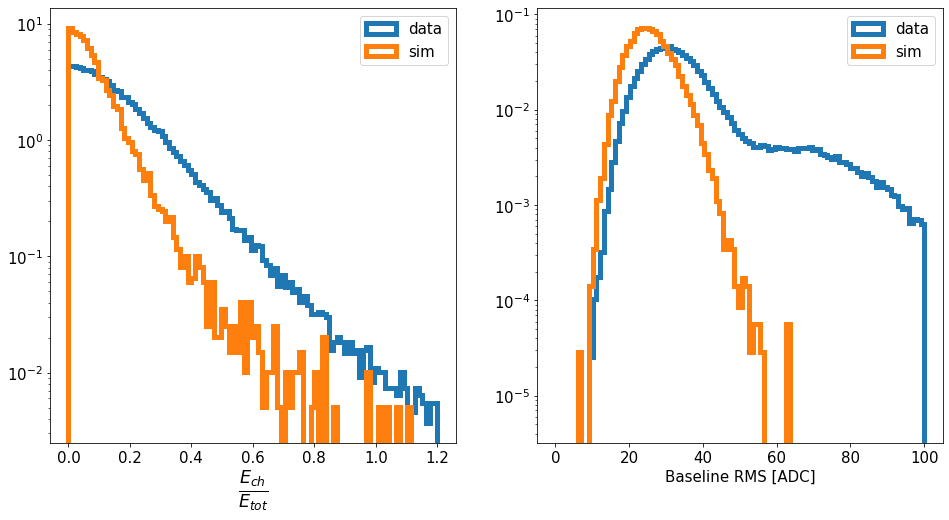

In [16]:
rms_ratio = {}
for rms_ch,ce_ch in zip(rms_keys,ce_keys):
    print(rms_ch)
    if '-' in rms_ch:
        bn = np.linspace(0,200,100)
    else:
        bn = np.linspace(0,100,100)
    mask_sim = (df_sim[ce_ch]/df_sim[rms_ch]<5) & np.logical_not(alpha_band_SS)
    mask_data = (df_data[ce_ch]/df_data[rms_ch]<5) & lower_band
    fig,ax = plt.subplots(1,2,figsize=(16,8))
    ax[0].hist(df_data[ce_ch][mask_data]/df_data['TotalTileEnergy'][mask_data],\
             bins=np.linspace(0,1.2,100),log=True,density=True,histtype='step',lw=5,label='data')
    ax[0].hist(df_sim[ce_ch][mask_sim]/df_sim['TotalTileEnergy'][mask_sim],\
             bins=np.linspace(0,1.2,100),log=True,density=True,histtype='step',lw=5,label='sim')
    ax[0].set_xlabel(r'$\frac{E_{ch}}{E_{tot}}$',fontsize=25)
    h_data,bn_data,_ = ax[1].hist(df_data[rms_ch][mask_data],bins=bn,log=True,density=True,histtype='step',lw=5,label='data')
    h_sim,bn_sim,_ = ax[1].hist(df_sim[rms_ch][mask_sim],bins=bn,log=True,density=True,histtype='step',lw=5,label='sim')
    ax[1].set_xlabel('Baseline RMS [ADC]')
    rms_ratio[rms_ch[10:-13]] = bn_sim[np.argmax(h_sim)]/bn_data[np.argmax(h_data)]
    ax[0].legend()
    ax[1].legend()
    plt.show()

In [17]:
import pickle
with open(path_to_reduced + '20201207_alpha_sim/test_noise_uncalibrated/noise_coefficient.p','wb') as f:
    pickle.dump(rms_ratio,f)

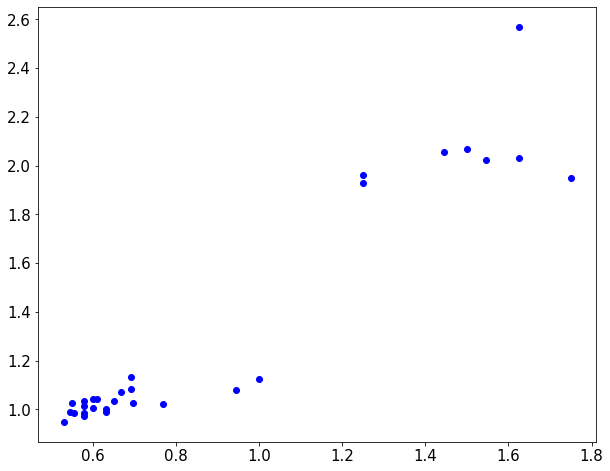

In [18]:
analysis_config.GetCalibrationConstantsFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run11b.csv')
analysis_config.calibration_constants['Calibration']
for ratio_k in rms_ratio:
    if ratio_k == 'X19':
        continue
    plt.scatter(1/rms_ratio[ratio_k], analysis_config.calibration_constants['Calibration'][ratio_k],c='blue')

[]

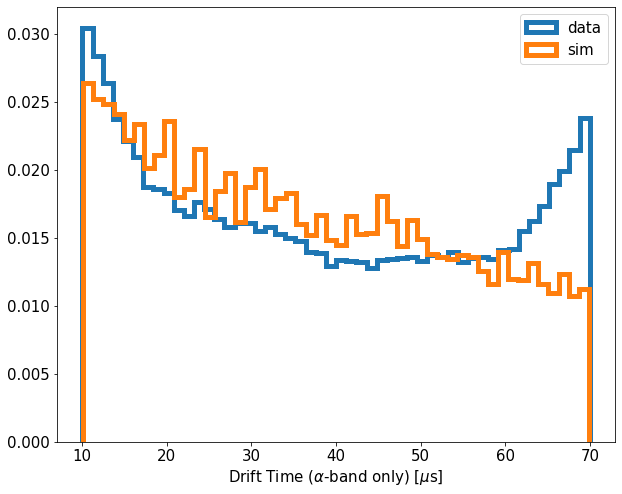

In [19]:
plt.hist(data_DriftTime[alpha_band],bins=50,density=True,histtype='step',lw=5,label='data')
plt.hist(DriftTime[alpha_band_SS],bins=50,density=True,histtype='step',lw=5,label='sim')
plt.xlabel(r'Drift Time ($\alpha$-band only) [$\mu$s]')
plt.legend()
plt.plot()

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


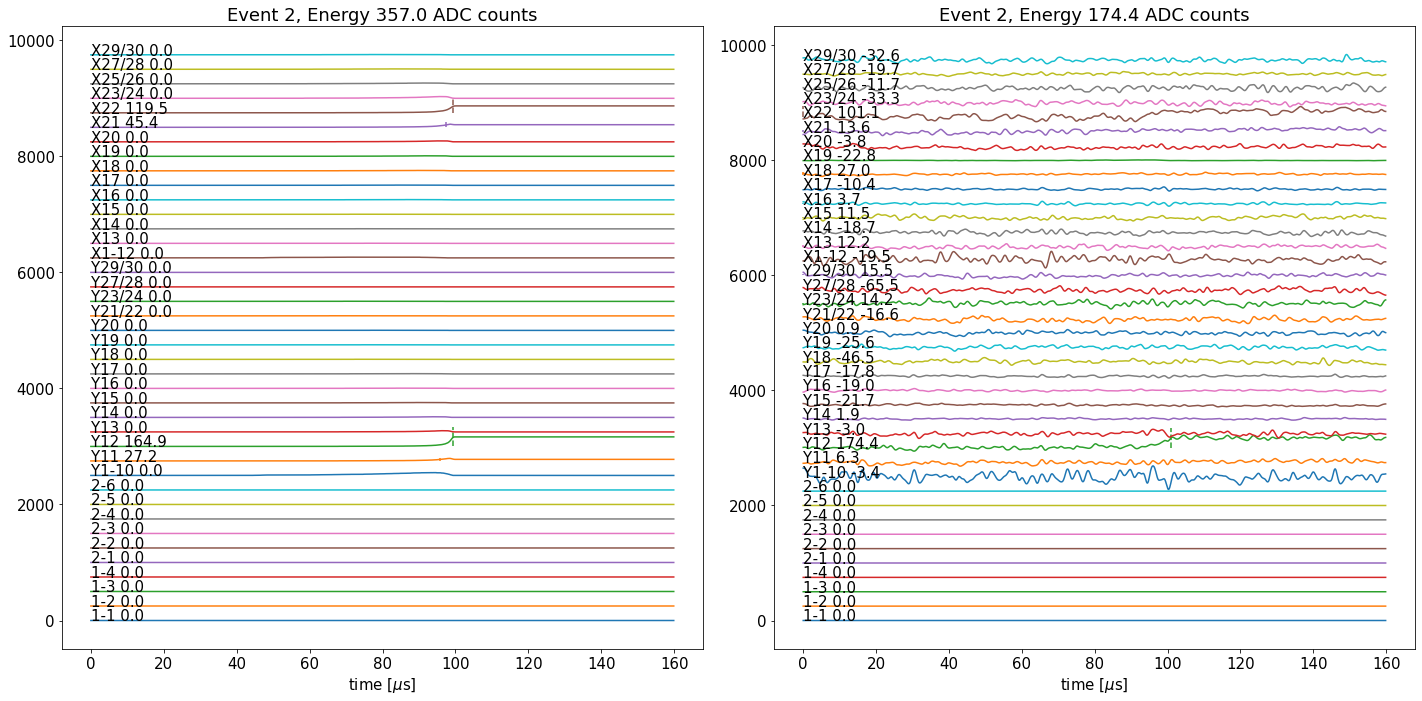

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


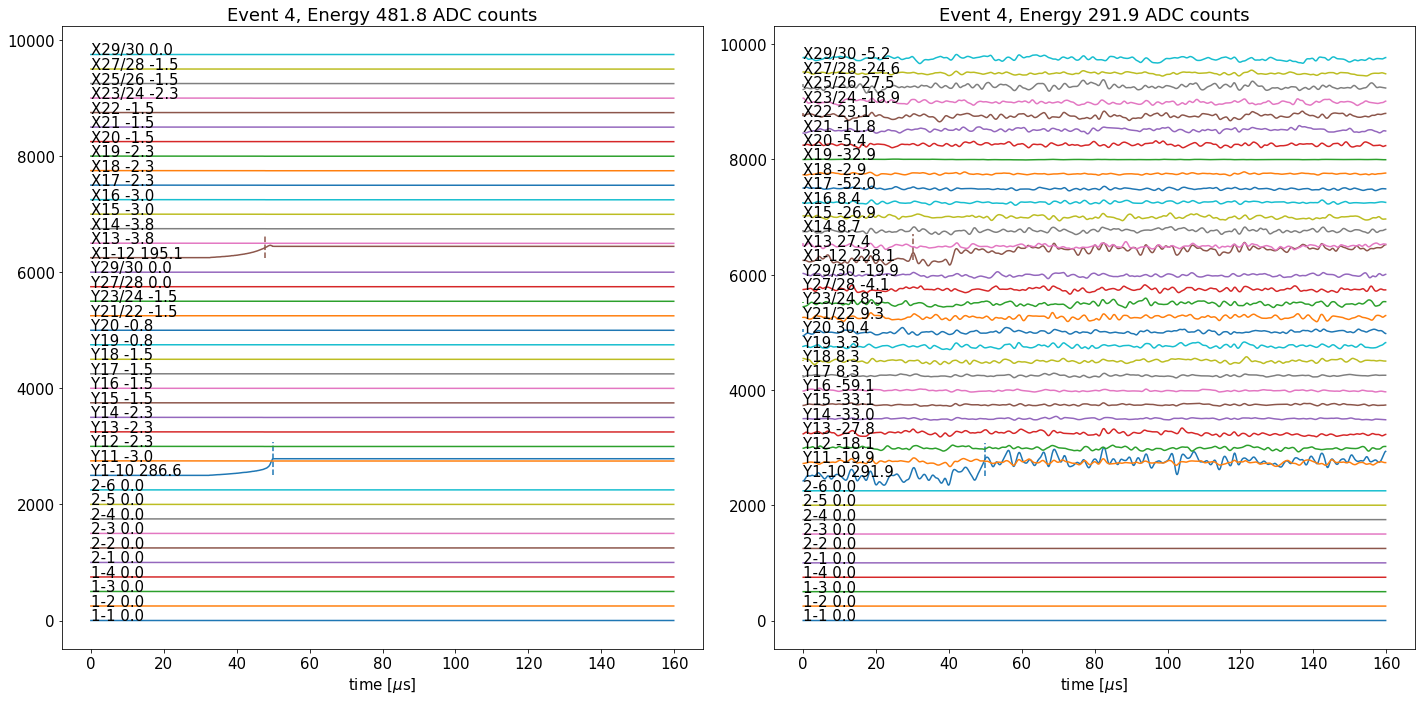

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


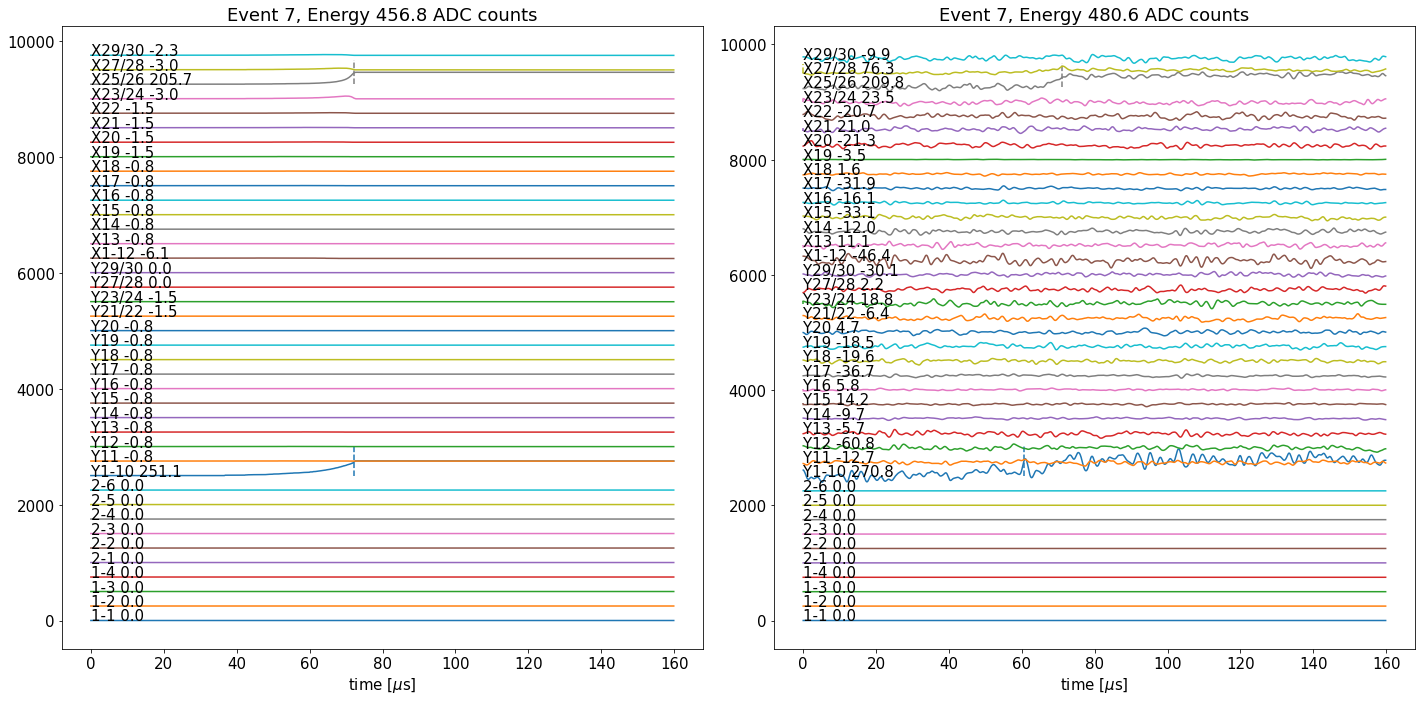

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


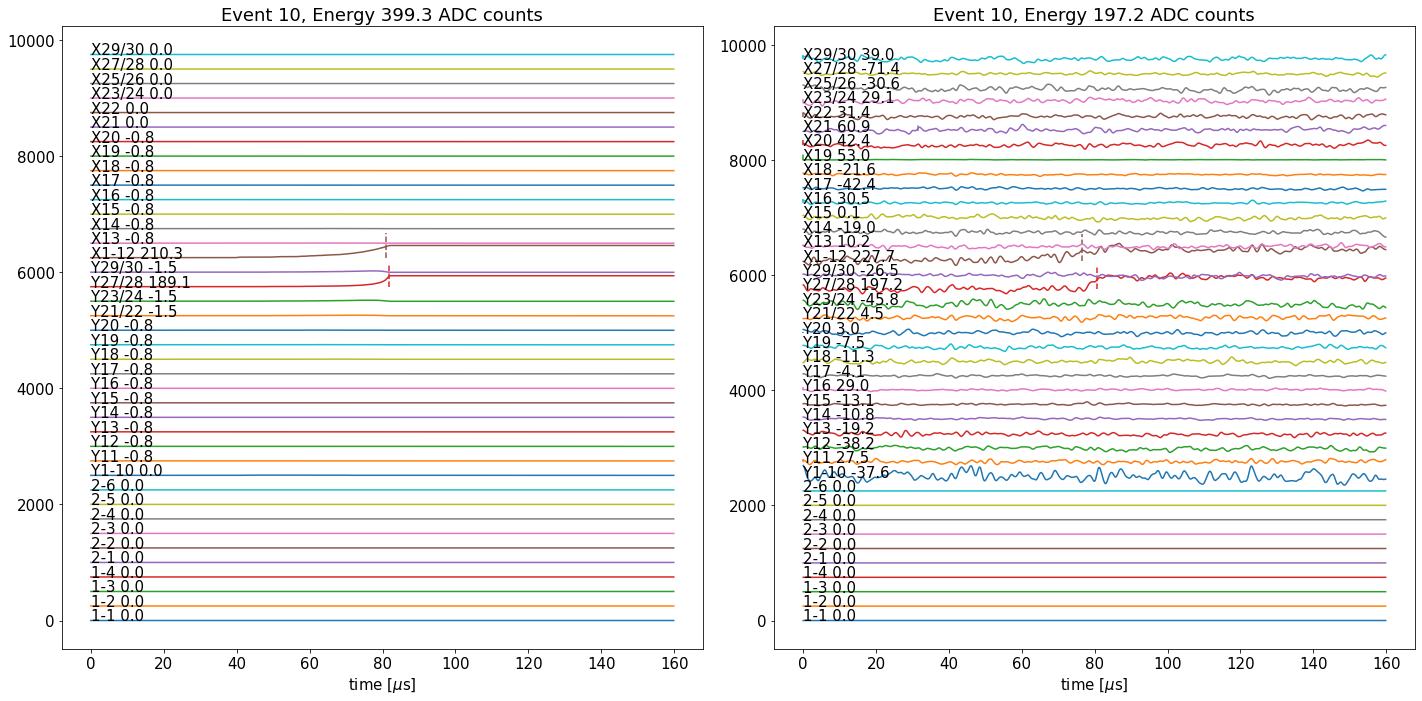

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


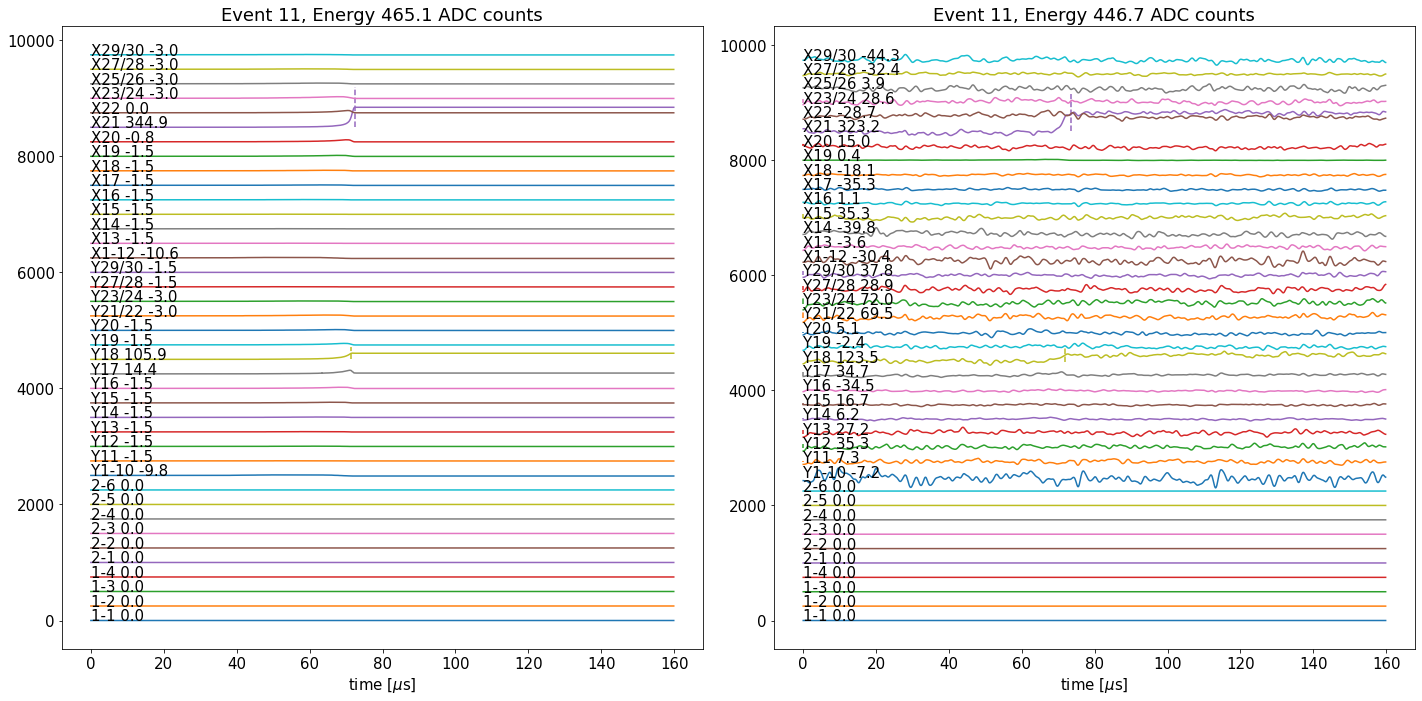

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


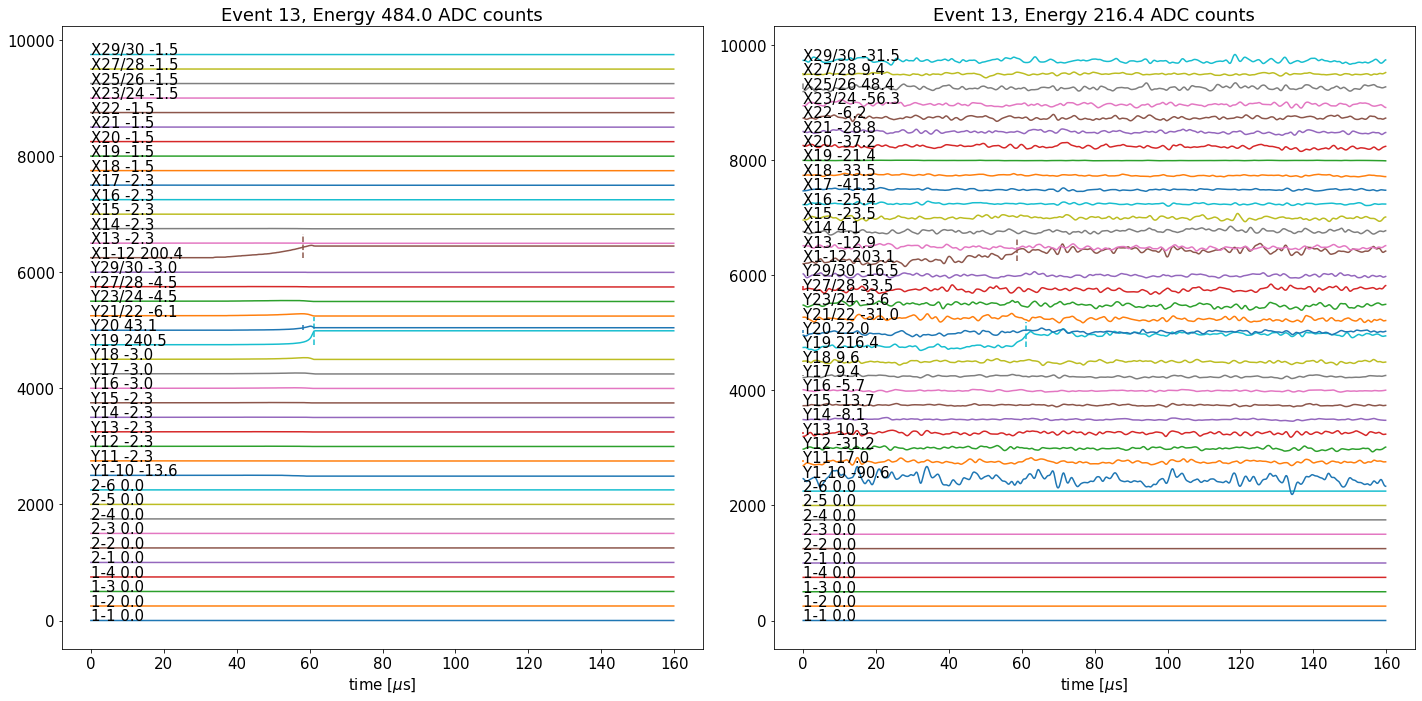

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


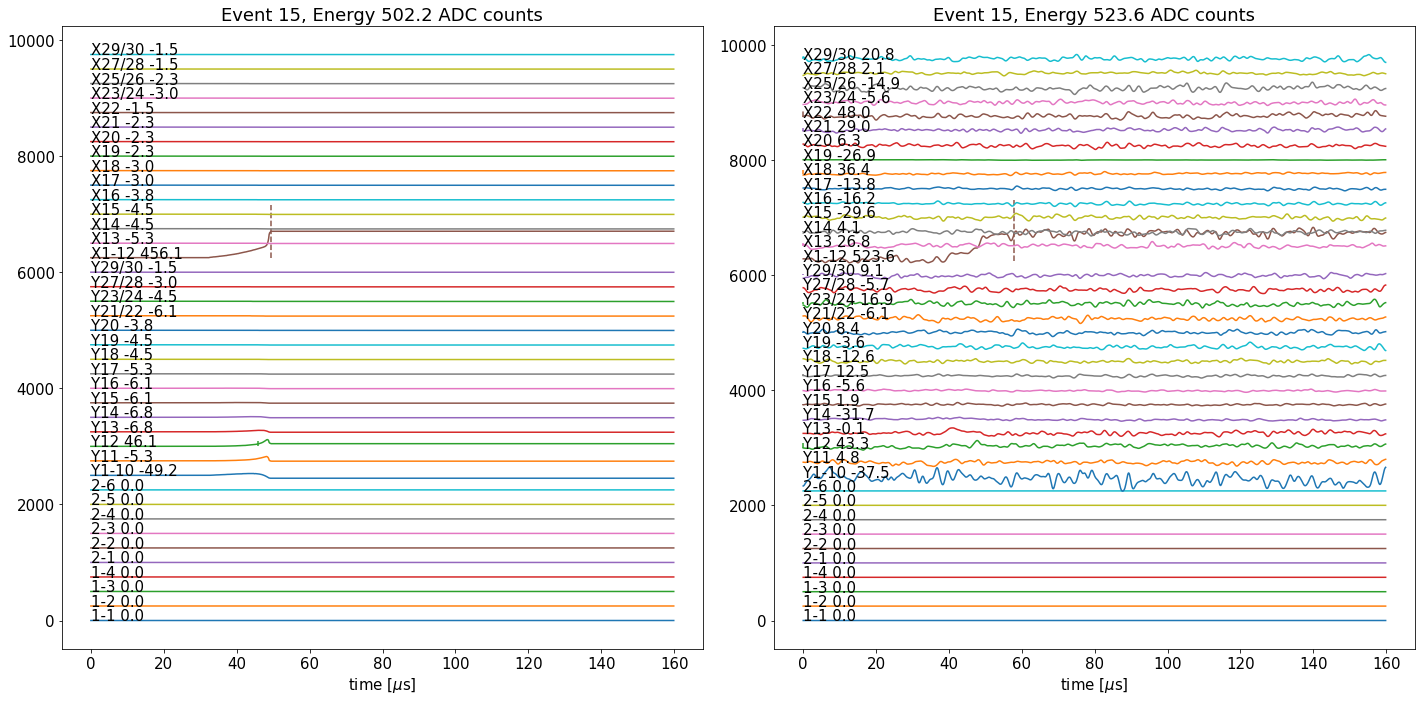

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


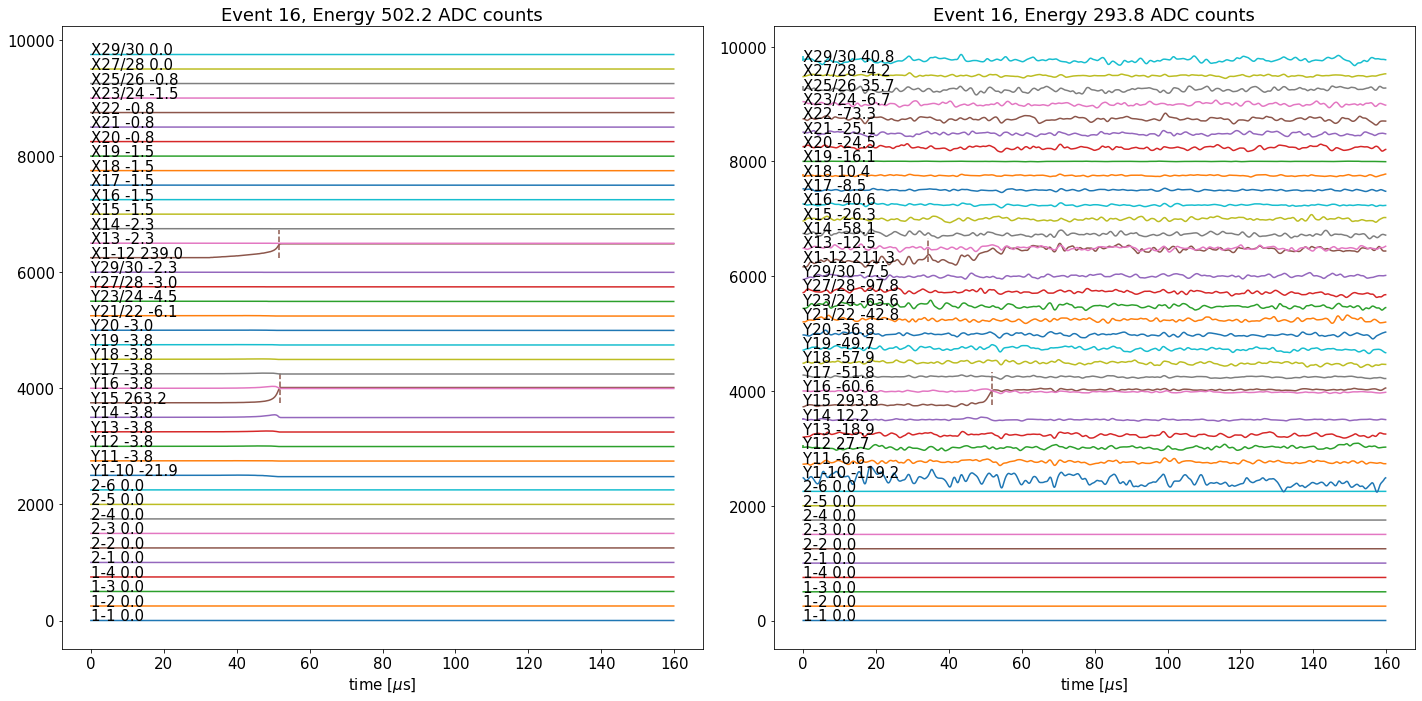

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


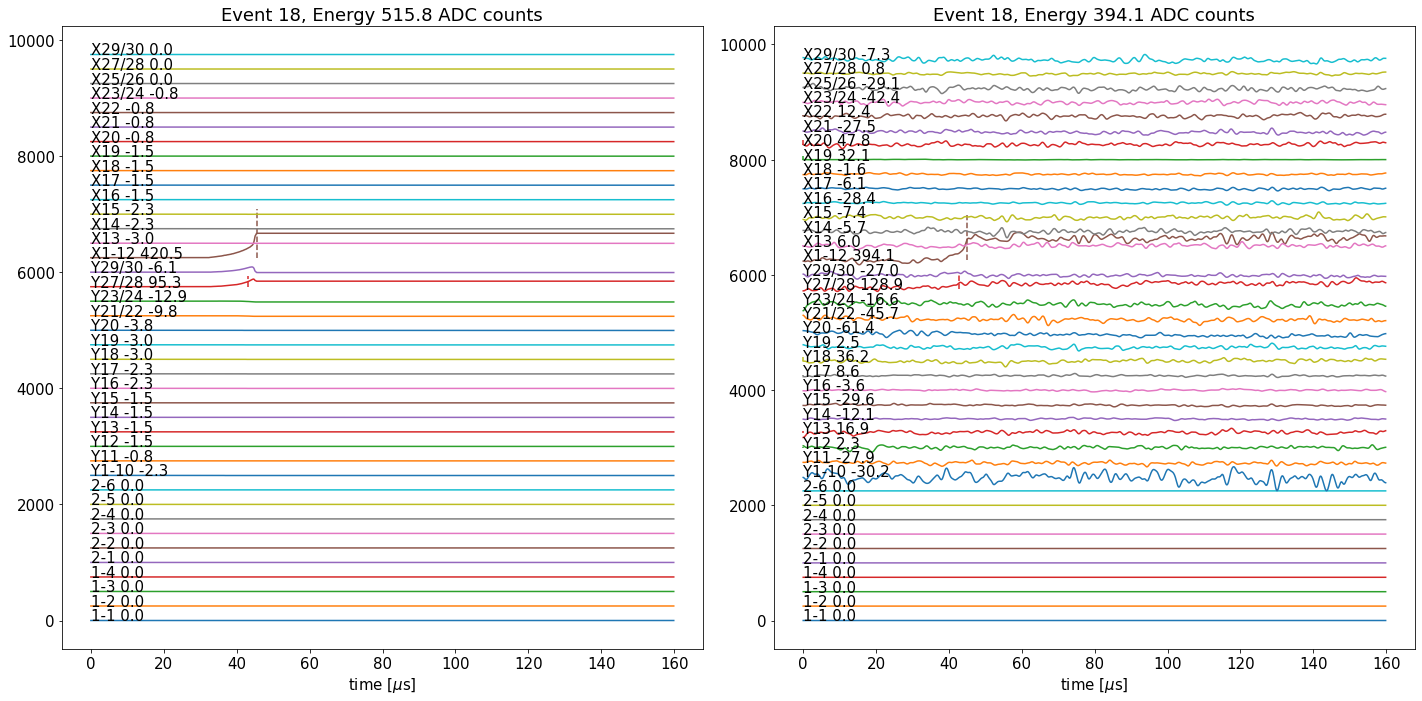

/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


/g/g90/jacopod/uproot/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Finished loading.


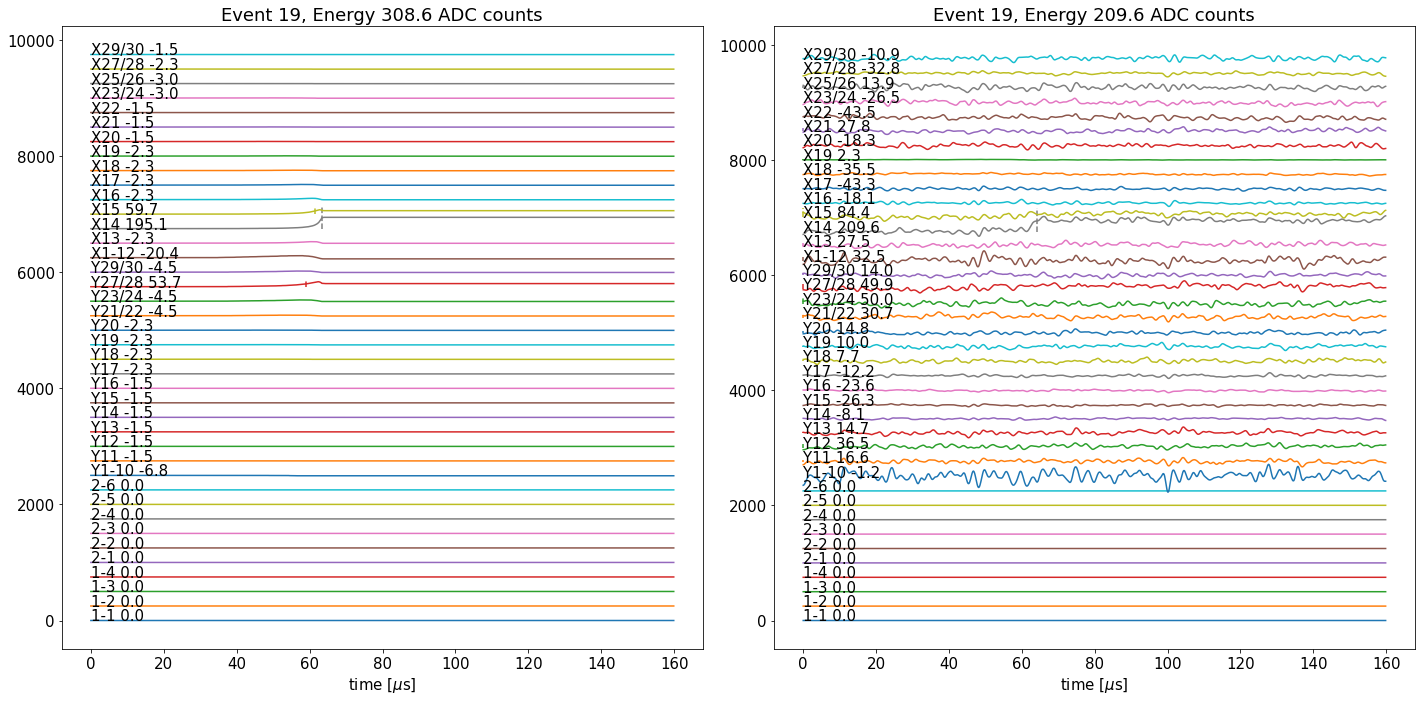

In [20]:
run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run30.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx'
for i in df_sim[np.logical_not(alpha_band_SS)].index[:10]:
    event = Waveform.Simulated_Event('/p/lustre1/jacopod/30th/20201207_alpha_sim/no_noise_500ns/reduced_added.p',\
                                     '/p/lustre1/lenardo1/stanford_teststand/simulations/Dec7_2020_alphas6207keV/',\
                                     i,\
                                     run_parameters_file,\
                                     calibrations_file,\
                                     channel_map_file,\
                                     add_noise=False)

    event1 = Waveform.Simulated_Event('/p/lustre1/jacopod/30th/20201207_alpha_sim/with_noise_500ns/reduced_added.p',\
                                     '/p/lustre1/lenardo1/stanford_teststand/simulations/Dec7_2020_alphas6207keV/',\
                                     i,\
                                     run_parameters_file,\
                                     calibrations_file,\
                                     channel_map_file,\
                                     add_noise=True)
    event1.smooth(0.5)
    #plot.show()
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    event.plot_event(True)
    plt.subplot(122)
    event1.plot_event(True)
    plt.show()